In [2]:
import cv2
import cloudpickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# load yalefaces dataset
dataset = {}

with open('./dataset/yalefaces.dump','rb') as f: 
    dataset = cloudpickle.load(f)

del dataset['gif']

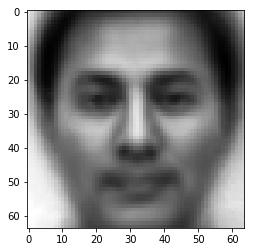

In [4]:
mean_global_face = np.zeros((1,64*64))

for class_label in dataset:
    for image in dataset[class_label]:
        mean_global_face = np.add(mean_global_face, image.flatten())

mean_global_face = np.divide(mean_global_face, 164.0)
plt.imshow(mean_global_face.reshape(64,64), cmap='gray')

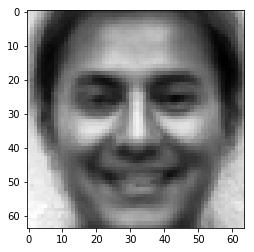

In [5]:
mean_face = {}

for class_label in dataset:
    mean_face[class_label] = np.zeros((1,64*64))
    for image in dataset[class_label]:
        mean_face[class_label] = np.add(mean_face[class_label], image.flatten())
    mean_face[class_label] = np.divide(mean_face[class_label], len(dataset[class_label]))
    
plt.imshow(mean_face['happy'].reshape(64,64), cmap='gray')

In [6]:
covariance_matrix = np.zeros((64*64, 64*64))
subtracted_mean_vector = {}

for class_label in dataset:
    subtracted_mean_vector[class_label] = mean_face[class_label] - mean_global_face
    covariance_matrix += np.divide( np.dot(subtracted_mean_vector[class_label].T, subtracted_mean_vector[class_label]) , len(dataset[class_label]))

eigen_vectors, eigen_values, _ = np.linalg.svd(covariance_matrix, full_matrices=False)
sort = eigen_values.argsort()[::-1]
eigen_values = eigen_values[sort]
eigen_vectors = eigen_vectors[:,sort]

In [23]:
THRESHOLD = 50

def find_k_best_eigen_values(eigen_values):
    sum_eigen_values = np.sum(eigen_values)
    for i in range(0, len(eigen_values)):
        if ((np.sum(eigen_values[:i]) / sum_eigen_values ) * 100 ) > THRESHOLD :
            return i

K = find_k_best_eigen_values(eigen_values)
selected_eigen_vector = eigen_vectors[:,0:K]

In [24]:
#transform image 
matrix_weight = {}

for class_label in dataset:
    matrix_weight[class_label] = np.dot(selected_eigen_vector.T, subtracted_mean_vector[class_label].T )

reconstructed_image_vector = {}

for class_label in dataset:
    reconstructed_image_vector[class_label] = mean_face[class_label] + np.dot(matrix_weight[class_label].T, selected_eigen_vector.T)

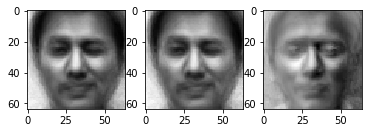

In [25]:
plt.subplot(1,3,1)
plt.imshow(reconstructed_image_vector['wink'].reshape((64,64)),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(mean_face['wink'].reshape((64,64)),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(reconstructed_image_vector['wink'].reshape((64,64)) - mean_face['wink'].reshape((64,64)),cmap='gray')